In [1]:
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py
import copy

# Project modules
from lib.Stokes import Stokes
from functions.plot_data import plot_data

In [2]:
# Open datafile
datafile = 'data/AR_12665_133153_0.h5'
print("Reading data file", datafile)
data = h5py.File(datafile, 'r')
print("Opened data file", data.file)

# Print data parameters
print("List of keys in file:", list(data.keys()))
key = list(data.keys())[0]
print("    Number of strokes parameters:   ", data[key].shape[0])
print("    Size of X axis:                 ", data[key].shape[1])
print("    Size of Y axis:                 ", data[key].shape[2])
print("    Number of measured wavelengths: ", data[key].shape[3])

Reading data file data/AR_12665_133153_0.h5
Opened data file <HDF5 file "AR_12665_133153_0.h5" (mode r)>
List of keys in file: ['stokes']
    Number of strokes parameters:    4
    Size of X axis:                  605
    Size of Y axis:                  768
    Number of measured wavelengths:  112


In [3]:
# Extract each Stokes parameter into dictionary
i = 0
I = Stokes('I', data['stokes'][0])
Q = Stokes('Q', data['stokes'][1])
U = Stokes('U', data['stokes'][2])
V = Stokes('V', data['stokes'][3])
stokes_list = {'I': I, 'Q': Q, 'U': U, 'V': V}
for stokes in stokes_list:
    print(stokes, 'shape:', stokes_list[stokes].data.shape)
    i = i + 1

I shape: (768, 605, 112)
Q shape: (768, 605, 112)
U shape: (768, 605, 112)
V shape: (768, 605, 112)


605 768
[0, 89.88485, 0, 122.88]


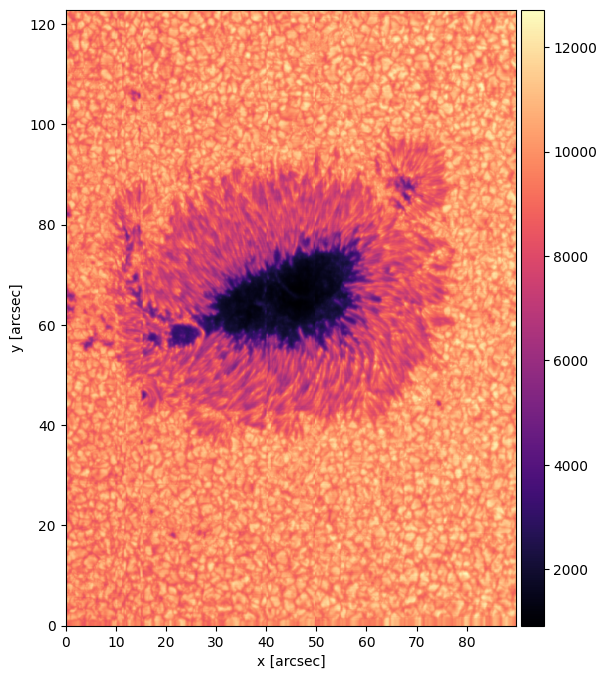

In [6]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 8))
ax.set_xlabel('x [arcsec]')
ax.set_ylabel('y [arcsec]')

plate_scale_x = 0.14857 # arcseconds per pixel
plate_scale_y = 0.16 # arcseconds per pixel
print(I.size_x, I.size_y)
img = ax.imshow(I.data[:,:,0], cmap='magma', origin='lower', extent=[0, I.size_x*plate_scale_x, 0, I.size_y*plate_scale_y])

print([0, I.size_x*plate_scale_x, 0, I.size_y*plate_scale_y])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img, cax=cax)

In [ ]:
np.flipud(data.swapaxes(0,1))

In [ ]:
# # Plot all figures to see where there is signal
# # Commented because it takes a few minutes to run

# nrows = 8
# ncols = 14

# fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(40, 28), dpi=25) # TODO: fix padding here

# for i in range(nrows):
#     for j in range(ncols):
#         # print("Image #", str(i*ncols +j), "in spot ", str(i), ", ", str(j))
#         # ax[i,j].set_title(I.name + " data, index " + str(i*ncols +j))
#         img = ax[i,j].imshow(I.data[:,:,(i*ncols + j)], cmap='gray')
#         ax[i,j].get_xaxis().set_visible(False)
#         ax[i,j].get_yaxis().set_visible(False)

# fig.tight_layout()
# fig.savefig("generated/" + str(I.name) + "_all_frames.png", dpi=150)
# print("Saved figure to file", "generated/" + str(I.name) + "_all_frames.png")

In [ ]:
# Plot all figures to see where there is signal
# Commented because it takes a few minutes to run
for param in stokes_list:
    fig = stokes_list[param].plot_all_frames()
    fig.savefig("generated/" + str(param) + "_all_frames.png", dpi=150)
    print("Saved figure to file", "generated/" + str(param) + "_all_frames.png")

In [ ]:
# Plot one image for each parameter where we are sure to have signal (after studying the plots at all wavelengths)
index_frame = 25
for param in stokes_list:
    stokes_list[param].plot_frame(index_frame)

In [ ]:
# Calculate total polarization

# Apply formula to each wavelength
mp = np.empty(I.data.shape)
for i in range(112):
    mp[:,:,i] = np.sqrt(Q.data[:,:,i]**2 + U.data[:,:,i]**2 + V.data[:,:,i]**2) / I.data[:,:,i]

In [ ]:
# Plot one frame of data
plot_data(mp[:,:,index_frame], "Polarization data, for wavelength index " + str(index_frame))

In [ ]:
# Select region of quiet sun for calibration intensity calculation
xmin = 440
xmax = I.data.shape[1] - 1
ymin = 600
ymax = I.data.shape[0] - 1
xwidth = xmax - xmin
ywidth = ymax - ymin
# We want to select a region with little total polarization, since this implies a low magnetic field -> quiet sun

# Plot polarization
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 8))
ax.set_xlabel('X axis (array index)')
ax.set_ylabel('Y axis (array index)')
ax.set_title("Polarization data")

img = ax.imshow(mp[:,:,index_frame], cmap='gray')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img, cax=cax)

# Create a rectangle patch and add the patch to the Axes
ax.add_patch(Rectangle((xmin, ymin), xwidth, ywidth, linewidth=2, edgecolor='r', facecolor='none'))


# Save figure to file
fig.savefig("generated/polarisation_selection_square.png", dpi=150)
print("Saved figure to file", "generated/polarisation_selection_square.png")

In [ ]:
# Calulate mean value of quiet sun area for each wavelength
# and plot the profile
fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(6, 7), sharex='col',)
i = 0
for param in stokes_list:
    stokes_list[param].mean_quiet_region(xmin, xmax, ymin, ymax)

    img = ax[i].plot(stokes_list[param].mean_quiet, color='purple')
    ax[i].set_title(param)
    fig.tight_layout()
    i +=1

ax[3].set_xlabel("Wavelength frame index")

# Save figure to file
fig.savefig("generated/3.quiet_sun_profiles.png", dpi=150)
print("Saved figure to file", "generated/3.quiet_sun_profiles.png")

In [ ]:
# Open calibration data
calibfile = 'data/fts_calibration.npz'
print("Reading calibration data file", calibfile)
calibdata = np.load(calibfile)
print("Opened calibration data file")

# Print data parameters
print("List of keys in file:", list(calibdata.files))
key = list(calibdata.files)
print("With shape:")
print("    Wavelength daya (x):           ", calibdata[key[0]].shape)
print("    Intensity (y):                 ", calibdata[key[0]].shape)
print("    Continuum (c):                 ", calibdata[key[0]].shape)

In [ ]:
# Get spectral lines from data spectrum
spectrum = copy.copy(I.mean_quiet)
peaks, _ = find_peaks(-spectrum)
print("Peaks in I data: ", peaks)
# TODO: figure out why it's getting four peaks
peaks = [29, 75]

# Example from here: https://eikonaloptics.com/blogs/tutorials/spectrometer-wavelength-calibration-practical-implementation?srsltid=AfmBOoqBsKn0cOmwJ4wTow4yGllnfrRJAqNRn0FOSJ3sFu7leDetbL1D
# Find centroid of spectral lines
npix = 4
centroid_pix = np.array([])
for p in peaks:
  pix = np.arange(p-npix, p+npix+1)
  centroid_pix = np.append(centroid_pix,
                 np.sum(spectrum[p-npix: p+npix+1] * pix) / np.sum(spectrum[p-npix: p+npix+1]))

print("Centroix pixels on spectrum: ", centroid_pix)

# Plot on spectrum
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))
ax.set_xlabel('Wavelength (not calibrated)')
ax.set_ylabel('Intensity')
ax.set_title("Mean intensity")
ax.vlines(centroid_pix, spectrum.min(), spectrum.max(), colors='orange')
img = ax.plot(spectrum)

In [ ]:
# Plot calibration data
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))
ax.set_xlabel('Wavelength')
ax.set_ylabel('Intensity')
ax.set_title("Calibration data")

img = ax.plot(calibdata['x'], calibdata['y'])

In [ ]:
# Get spectral lines from calibration spectrum
calib_spectrum = calibdata['y']
calib_peaks, _ = find_peaks(-calib_spectrum) # find absortion lines
print("Peaks in calibration data: ", calib_peaks)
# Keep peaks which match the Fe I lines (manually)
calib_peaks_clean = [210, 347]

# Get wavelength values of Fe I peaks
calib_wavelengths = [calibdata['x'][210], calibdata['x'][347]]
print("Wavelengths of Fe I peaks: ", calib_wavelengths)

# Plot calibration data
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Intensity')
ax.set_title("Calibration reference data")
ax.vlines(calib_wavelengths, calib_spectrum.min(), calib_spectrum.max(), colors='grey', linestyles='dashed')
img = ax.plot(calibdata['x'], calibdata['y'], color='purple')


# Save figure to file
fig.savefig("generated/3.calibration_reference_lines.png", dpi=150)
print("Saved figure to file", "generated/3.calibration_reference_lines.png")

In [ ]:
# Calculate polynomial which fits the spectra to the calibration wavelengths
poly_degree = 1
coeffs_wave_cal = np.polyfit(centroid_pix, calib_wavelengths, deg=poly_degree, w=[20,2])
print("Polyfit coefficients: ", coeffs_wave_cal)

plt.plot(np.polyval(coeffs_wave_cal, np.arange(112)))
plt.title("Polyfit results")

In [ ]:
# Adjust spectrum with the calculated polynomial
pix_val = np.arange(len(spectrum))
calibrated_axis = np.polyval(coeffs_wave_cal, pix_val)

# Plot the spectrum with the newly calibrated wavelengths.
plt.figure(figsize=(8,5))
plt.plot(calibrated_axis, spectrum)
plt.xlabel('Calibrated wavelength [nm]')

In [ ]:
# Normalize spectrum and calibration data, mean of first value
spectrum_n = spectrum / spectrum[0]
calibdata_n = calibdata['y'] / calibdata['y'][0] # this is wrong but useful for visual confirmation

# Compare calibrated spectum to calibration data
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Intensity (normalized)')
ax.set_title("Calibrated spectrum (orange) plotted over calibration data (purple)")
ax.set_xlim([6300, 6304])
ax.vlines(calib_wavelengths, calibdata_n.min(), calibdata_n.max(), colors='grey', linestyles='dashed')
img = ax.plot(calibdata['x'], calibdata_n, color='purple')
img = ax.plot(calibrated_axis, spectrum_n, color='orange')


# Save figure to file
fig.savefig("generated/3.calibration_both_spectra.png", dpi=150)
print("Saved figure to file", "generated/3.calibration_both_spectra.png")

In [ ]:
# Add wavelength axis to objects
for param in stokes_list:
    stokes_list[param].add_wavelength(calibrated_axis)

In [ ]:
# Calculate I continuum value by averaging the first 5 pixels
I_cont = I.mean_quiet[:5].mean()

# Normalize all datacubes by didiving by the wavelength
for param in stokes_list:
    stokes_list[param].normalize(I_cont)

In [ ]:
# Plot normalized data, all Stokes parameters for the spectral line, where wavelength = 6301.5 nm
wavelength = 6301.5
for param in stokes_list:
    fig = stokes_list[param].plot_frame_n(25)
    fig.savefig("generated/" + str(param) + "_frame_25.png", dpi=200)
    print("Saved figure to file", "generated/" + str(param) + "_frame_25.png")

In [ ]:
# Calculate polarizations, plot images

from lib.Derived import Derived

# Initializing derived parameter object
derived = Derived(stokes_list)

# Calculate total polarization
print("Calculaing total polarization")
derived.total_polarization()
fig, _ = derived.plot_total_polarization()
fig.savefig("generated/" + "total_polarization.png", dpi=200)
print("Saved figure to file", "generated/total_polarization.png")


# Calculate linear polarization
print("Calculaing linear polarization")
derived.linear_polarization()
fig, _ = derived.plot_linear_polarization()
fig.savefig("generated/" + "linear_polarization.png", dpi=200)
print("Saved figure to file", "generated/linear_polarization.png")

# Calculate circular polarization
print("Calculaing circular polarization")
derived.circular_polarization()
fig, _ = derived.plot_circular_polarization()
fig.savefig("generated/" + "circular_polarization.png", dpi=200)
print("Saved figure to file", "generated/circular_polarization.png")

In [ ]:
derived.save_pickle()
stokes.save_pickle()

In [ ]:
plot_data(derived.mp, "Total polarization", scale=None, norm="log")
plot_data(derived.lp, "Linear polarization", scale=None, norm="log")
plot_data(derived.cp, "Circular polarization", scale=None, norm="log")